In [1]:
#先準備標註好的訓練資料>老師提供
#/content/drive/MyDrive/train.zip
import zipfile
path = "/content/drive/MyDrive/2021-AI/2021-機器學習/DL-additional/additional/train.zip"
f = zipfile.ZipFile(path)
#下面是做解壓縮,括弧內沒填就是先丟到colab的暫存主機中
f.extractall()

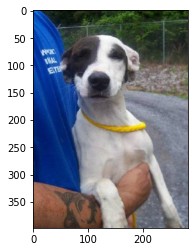

In [2]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
#測試印出資料,編號第10000張
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[10000]))

In [3]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
#洗牌,打亂排序
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
#取90%資料做訓練
train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})
#取5%資料作驗證訓練,5%作完全未知測試
validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})
test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

In [4]:
#VGG16是一個訓練過的model,裡面是辨識生物特徵
#這邊對他做遷移學習，只拿他的CNN萃取特徵,MLP分類器我們自己定義
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
#沒有加的時候 發現商算出來的loss有超過1，這代表錯誤率>50% , 又看到準確率=1(sigmoid的邊界)>>>明顯有問題
#CNN 和 MLP之間 , 要做Normalization(要做橋接) , 預測機率才不會有問題
#保險起見>在座遷移式學習時,使用別人的CNN,就要固定在CNN&MLP之間做Normalization
from tensorflow.keras.layers import BatchNormalization
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
# compile前就設定好,每一層都設定成False > freeze
for l in cnn.layers:
    l.trainable = False
# 這裡定義分類器 > 用GAP,最後分成兩種,因為互斥所以用Softmax
clf = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + clf)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                         

In [5]:
# 一個輸出(二元分類): BinaryCrossEntropy p log 1/q + (1 - p) log 1/1-q
# 多個輸出(多元分類): CategoricalCrossEntropy pi log1/qi
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              # "adam"也可以
              optimizer="adam",
              metrics=["accuracy"])

In [6]:
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [7]:
from PIL import Image
#預處理,vgg16採用的是caffee框架,可以在下面網址找到框架說明
#https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
#caffee處理資料:先把RGB>BGR , 再計算平均後 ,減去平均值>zerocenter (把中心降為0)
from tensorflow.keras.applications.vgg16 import preprocess_input
#定義資料處理函式
def get_data(x, y, batch=None):
    #batch預設為None(代表資料範圍是全部)
    if batch is not None:
        #np.random.eandint會不包含len(x)本身
        idx = np.random.randint(0, len(x), size=batch)
        print(idx)
        x, y = x[idx], y[idx]
    img_pre, img_ori = [], []
    for p in x:
        #圖片規格化
        img = Image.open(p).convert("RGB").resize((224, 224))
        #轉成np.array
        img = np.array(img)
        #轉預處理格式(caffee框架)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    return (np.array(img_pre), np.array(img_ori), y)
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

[ 403 1572  301 1049  534  949 1551 1720  424  606]
(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [8]:
#對驗證及測試資料同樣做處理
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [9]:
#這邊開始自己寫訓練&預測流程,一個batch做一次梯度下降
for i in range(200):
    # _ 代表這個參數沒有用到
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)
    #做到後面發現>loss有在降,但是acc沒有 >> 代表預測得越來越準,但是原本辨識不出來的案例還是沒有解決

[ 260  593   84 1122 1269  323 1103 1100 1269  635  490  581  970 1630
  997  719  365 1201 1019 1236]
train: [0.6017041206359863, 0.75]
validate: [0.7728757262229919, 0.7400000095367432]
--------------- 0 end ---------------
[ 316 1596  763  869  207  413  331  863  196  923  191 1060  219   87
  716  656 1343 1373  812 1202]
train: [0.6026272177696228, 0.75]
validate: [0.6050002574920654, 0.75]
--------------- 1 end ---------------
[1769 1382 1170 1232  319  189  546  217  703 1792  351  585  973  540
 1184 1693  538  618  654   61]
train: [0.6740972399711609, 0.6000000238418579]
validate: [0.5217866897583008, 0.800000011920929]
--------------- 2 end ---------------
[ 428  447 1757 1392 1297  997 1360 1167  417  927  678 1355  190 1719
  395  872  578 1729 1745 1252]
train: [0.520330011844635, 0.8500000238418579]
validate: [0.47843047976493835, 0.800000011920929]
--------------- 3 end ---------------
[1140  682  543  521  109 1667  910 1792  438   22 1136   73  201 1321
 1373 1265 11

In [10]:
pre = model.predict(xt).argmax(axis=1)
model.evaluate(xt, yt)

4/4 [==============================] - 1s 192ms/step - loss: 0.1265 - accuracy: 0.9600


[0.12646645307540894, 0.9599999785423279]

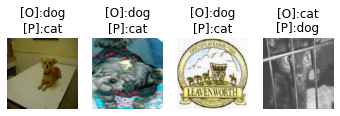

In [11]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != yt)[0]
idx = idx[:200]
pre_false_label = yt[idx]
pre_false_pre = pre[idx]
pre_false_img = xt_ori[idx]
# !
trans = ["dog", "cat"]
plt.figure(figsize=(15, 5))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

url:https://images.twgreatdaily.com/images/elastic/POf/POfzNm8BMH2_cNUgpnmk.jpg
dog 的機率: 0.018
cat 的機率: 0.982


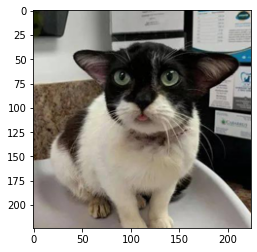

In [12]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)